In [21]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from distancia import haversine

In [84]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [69]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [70]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

En este dataset trabajaremos con algunas columnas de interes, las cuales clasificamos a continuacion dependiendo el tipo de variable:

*   **fare_amount:**   cuantitativa continua
*   **pickup_datetime:** cualitativa nominal
*   **pickup_longitude:** cuantitativa continua
*   **pickup_latitude:** cuantitativa continua
*   **dropoff_longitude:** cuantitativa continua
*   **dropoff_latitude:** cuantitativa continua
*   **passenger_count:** cuantitativa discreta

Lo primero que realizaremos será utilizar el método `.info()` para verificar que el tipo de dato en cada variable es correcto, detectar la presencia de valores nulos y valores atípicos.

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


### Limpieza de los datos
Podemos observar a traves del 'df.info' que tenemos 200.000 datos donde las columnas 'dropoff_longitude' y 'dropoff_latitude' poseen un valor faltante en sus datos. Consideramos que al tener una muestra de datos abundante, decidimos eliminarlos del dataset ya que no afecta al entrenamiento del modelo y evitar imputar los datos con un valor promedio. Además, modificamos el tipo de dato de 'pickup_datetime' para verificar que todas las fechas ingresadas hayan sido correctamente cargadas.

In [85]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])                   # Cambia el tipo de dato object -> datetime
df.dropna(inplace=True)                                                         # Elimina las filas con valores nulos

# Eliminación de columnas que no son de interes
df = df.drop('key', axis = 1)
df = df.drop('date', axis = 1)

Luego de esto, realizamos un 'describe' sobre las variables numericas y consideramos los resultados para analizar cada variable del dataset.

In [86]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543
std,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


##### **Análisis de la columna `passenger_count`:**

A partir del análisis exploratorio mediante `df.describe()`, se detectó que el valor máximo registrado en la variable fue de 208 pasajeros por viaje, lo cual constituye un error en la carga de datos. Para visualizar la distribución se realizaron diferentes gráficos:  

- En el **primer boxplot**, se observa claramente el valor atípico de 208, lo que impide una correcta interpretación del resto de los datos.  
- Al excluir dicho valor extremo, el **segundo boxplot** permite observar mejor la dispersión real de la variable.  

Además, se identificaron registros con 0 pasajeros, los cuales también son inconsistentes, ya que un viaje no puede realizarse sin pasajeros.  


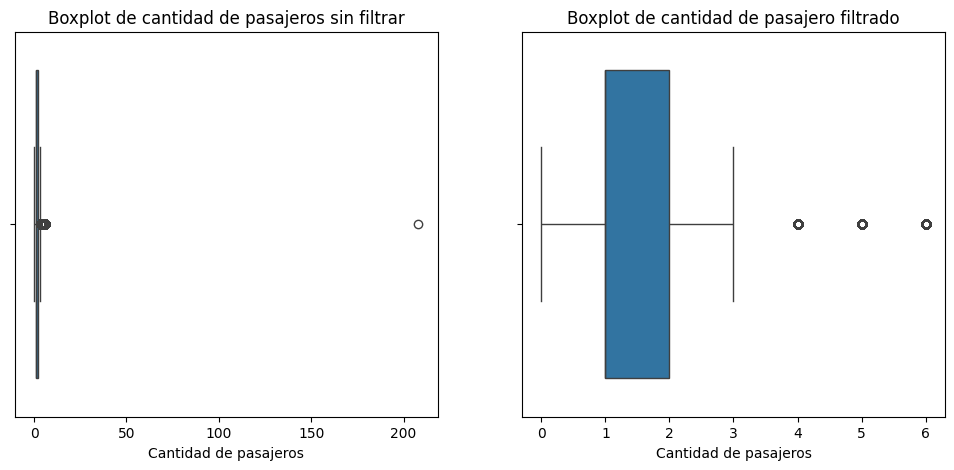

In [87]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.boxplot(x = df['passenger_count'])
plt.title('Boxplot de cantidad de pasajeros sin filtrar')
plt.xlabel('Cantidad de pasajeros')

plt.subplot(1, 2, 2)
sns.boxplot(x = df[df['passenger_count'] < 208]['passenger_count'])
plt.title('Boxplot de cantidad de pasajero filtrado')
plt.xlabel('Cantidad de pasajeros')

plt.show()

Para solucionar este problema y no eliminar dichos registros, se decidió imputar el valor atípico de 208 y tratar los datos con 0 pasajeros con la **mediana de la distribución**. La mediana es la medida de tendencia central y es robusta frente a valores atípicos y representa de forma adecuada la cantidad más común de pasajeros en los viajes (generalmente 1). Finalmente, la columna fue convertida a valores enteros para mantener consistencia en la variable.


In [88]:
from sklearn.impute import SimpleImputer

df.loc[df['passenger_count'] == 208, 'passenger_count'] = pd.NA
df.loc[df['passenger_count'] == 0, 'passenger_count'] = pd.NA
imputer = SimpleImputer(strategy='median')                                      # Imputar con la mediana
df['passenger_count'] = imputer.fit_transform(df[['passenger_count']])
df['passenger_count'] = df['passenger_count'].astype(int)

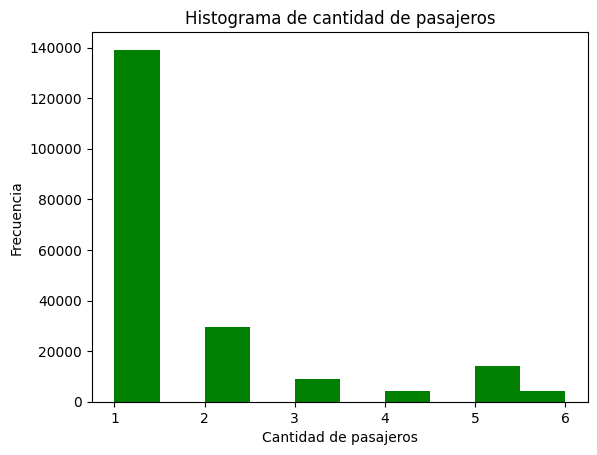

In [91]:
plt.hist(df['passenger_count'], color = 'green')
plt.title('Histograma de cantidad de pasajeros')
plt.xlabel('Cantidad de pasajeros')
plt.ylabel('Frecuencia')
plt.show()

##### Análisis de las columnas `pickup_latitude`, `dropoff_latitude`, `pickup_longitude` y `dropoff_longitude`

Para analizar estos datos, lo primero que realizamos fue la visualización gráfica de cada variable. En estas gráficas se observan bastantes valores atípicos que no corresponden a la zona de estudio de interes. Dado que el dataset corresponde a viajes realizados en la ciudad de **New York**, se decidió aplicar un filtro basado en su ubicación geográfica:  

- **Rangos globales válidos**:  
  - Latitud: -90 a 90  
  - Longitud: -180 a 180  

- **Rangos aproximados para New York**:  
  - Latitud: 40.50 a 41.00  
  - Longitud: -74.20 a -73.60  

De esta manera, se eliminan registros con coordenadas fuera de este rango, ya que son considerados como datos no representativos de la zona de análisis.

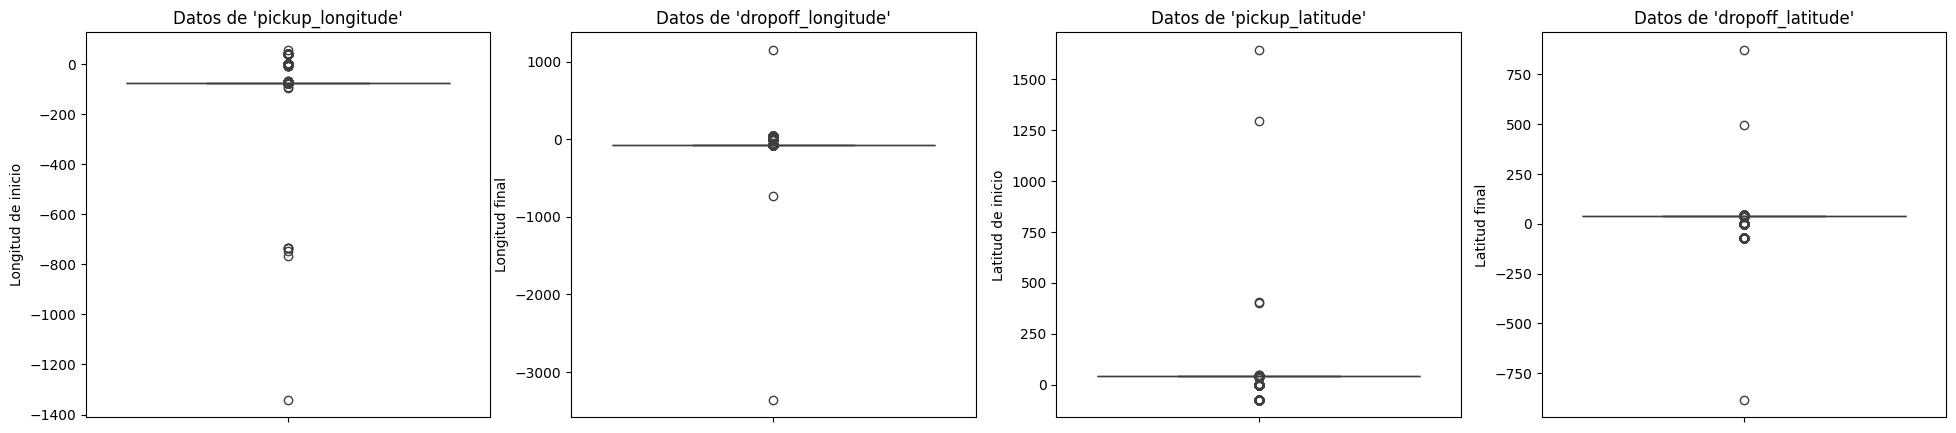

In [92]:
plt.figure(figsize=(24,5))

plt.subplot(1, 4, 1)
plt.title("Datos de 'pickup_longitude'")
sns.boxplot(df['pickup_longitude'])
plt.ylabel('Longitud de inicio')

plt.subplot(1, 4, 2)
plt.title("Datos de 'dropoff_longitude'")
sns.boxplot(df['dropoff_longitude'])
plt.ylabel('Longitud final')

plt.subplot(1, 4, 3)
plt.title("Datos de 'pickup_latitude'")
sns.boxplot(df['pickup_latitude'])
plt.ylabel('Latitud de inicio')

plt.subplot(1, 4, 4)
plt.title("Datos de 'dropoff_latitude'")
sns.boxplot(df['dropoff_latitude'])
plt.ylabel('Latitud final')

plt.show()

In [93]:
longitud = df[(df['pickup_longitude'] == 0.00) & (df['dropoff_longitude'] == 0.00)].value_counts().sum()  # 3587 datos
latitud = df[(df['pickup_longitude'] == 0.00) & (df['dropoff_longitude'] == 0.00)].value_counts().sum()   # 3587 datos
lat_long = df[(df['pickup_latitude'] == 0.00) & (df['dropoff_latitude'] == 0.00) & (df['pickup_longitude'] == 0.00) & (df['dropoff_longitude'] == 0.00)].value_counts().sum()
print(f'datos nulos en latitud y longitud: {lat_long}') # 3587 datos
print(f'datos nulos en longitud: {longitud}')
print(f'datos nulos en latitud: {latitud}\n')

longitud1 = df[df['dropoff_longitude'] == 0.00].value_counts().sum()  # 177 datos
longitud2 = df[df['pickup_longitude'] == 0.00].value_counts().sum()   # 199 datos 
latitud1 = df[(df['pickup_latitude'] == 0.00)].value_counts().sum()   # 177 datos 
latitud2 = df[(df['dropoff_latitude'] == 0.00)].value_counts().sum()  # 171 datos 
print(f'datos nulos en longitud inicio: {longitud2}')
print(f'datos nulos en longitud final: {longitud1}')
print(f'datos nulos en latitud inicio: {latitud1}')
print(f'datos nulos en latitud final: {latitud2}\n')

datos nulos en latitud y longitud: 3587
datos nulos en longitud: 3587
datos nulos en latitud: 3587

datos nulos en longitud inicio: 3786
datos nulos en longitud final: 3764
datos nulos en latitud inicio: 3782
datos nulos en latitud final: 3758



Podemos observar que existen registros en los cuales tanto la latitud como la longitud (de inicio y de destino) tienen valor igual a 0. Estos registros no aportan información relevante al análisis, ya que corresponden a errores de carga, por lo que se decidió **eliminarlos del dataset** para trabajar únicamente con datos reales.  

Por otro lado, aquellos registros en los que solo **una de las coordenadas** (latitud o longitud, ya sea en inicio o destino) tiene valor igual a 0, pueden ser recuperados. En este caso, en lugar de eliminarlos, se optó por reemplazar dichos valores utilizando el método de imputación por K-vecinos más cercanos (KNN), lo cual permite estimar las coordenadas faltantes en base a los viajes más similares.

In [95]:
from sklearn.impute import KNNImputer

# Eliminar filas con todas las coordenadas en 0
indices_invalidos = df[(df['pickup_latitude'] == 0.00) &(df['dropoff_latitude'] == 0.00) &(df['pickup_longitude'] == 0.00) &(df['dropoff_longitude'] == 0.00)].index
df = df.drop(indices_invalidos)

columnas = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
#k muy pequeño → más sensible a ruido. k muy grande → valores muy suavizados, se pierde variabilidad real.
# Reemplazar 0.0 por NaN para que KNNImputer los impute
df[columnas] = df[columnas].replace(0.0, np.nan)

# Crear imputador KNN
knn_imputer = KNNImputer(n_neighbors=5)
df[columnas] = knn_imputer.fit_transform(df[columnas]).round(6)

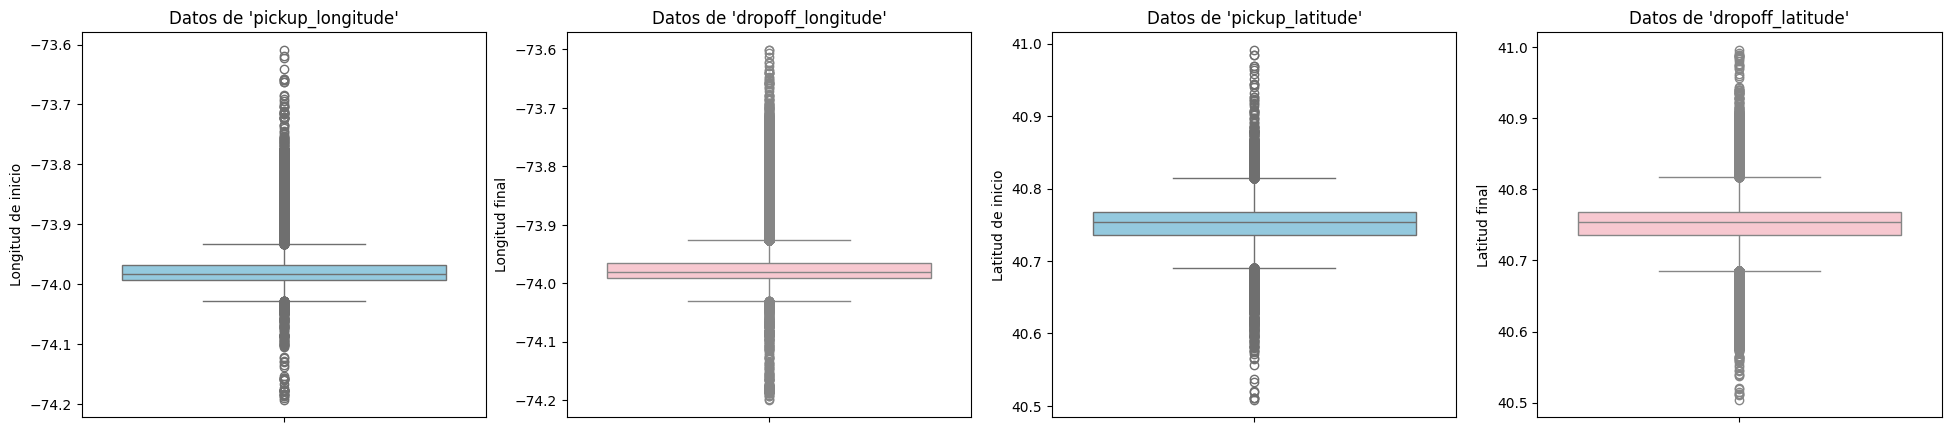

In [96]:
plt.figure(figsize=(24,5))

plt.subplot(1, 4, 1)
plt.title("Datos de 'pickup_longitude'")
sns.boxplot(df[(df['pickup_longitude'] > -74.2) & (df['pickup_longitude'] < -73.6)]['pickup_longitude'], color="skyblue")
plt.ylabel('Longitud de inicio')


plt.subplot(1, 4, 2)
plt.title("Datos de 'dropoff_longitude'")
sns.boxplot(df[(df['dropoff_longitude'] > -74.2) & (df['dropoff_longitude'] < -73.6)]['dropoff_longitude'], color="pink")
plt.ylabel('Longitud final')

plt.subplot(1, 4, 3)
plt.title("Datos de 'pickup_latitude'")
sns.boxplot(df[(df['pickup_latitude'] > 40.5) & (df['pickup_latitude'] < 41)]['pickup_latitude'], color="skyblue")
plt.ylabel('Latitud de inicio')

plt.subplot(1, 4, 4)
plt.title("Datos de 'dropoff_latitude'")
sns.boxplot(df[(df['dropoff_latitude'] > 40.5) & (df['dropoff_latitude'] < 41)]['dropoff_latitude'], color="pink")
plt.ylabel('Latitud final')

plt.show()

tenemos 1 nulo en dropoff_longitude y dropoff_latitude

In [7]:
# Agregar mas caraterísticas a partir de las coordenadas geográficas
df["delta_lat"] = df["dropoff_latitude"] - df["pickup_latitude"]
df["delta_lon"] = df["dropoff_longitude"] - df["pickup_longitude"]

df["distance_km"] = df.apply(
    lambda row: haversine(
        row["pickup_longitude"], row["pickup_latitude"],
        row["dropoff_longitude"], row["dropoff_latitude"]
    ),
    axis=1
)
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,delta_lat,delta_lon,distance_km
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,-0.015137,0.000305,1.683323
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,0.022100,-0.000355,2.457590
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,0.031877,0.042478,5.036377
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,0.012505,0.010808,1.661683
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,0.017162,-0.048059,4.475450


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='fare_amount'), df['fare_amount'], test_size=0.2, random_state=42)

In [9]:
X_train.describe()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,delta_lat,delta_lon,distance_km
count,1.600000e+05,160000.000000,160000.000000,159999.000000,159999.000000,160000.000000,159999.000000,159999.000000,159999.000000
mean,2.771233e+07,-72.525896,39.936265,-72.525260,39.919258,1.684988,-0.017002,0.000627,20.591193
std,1.603218e+07,11.557753,8.090121,13.611271,6.880320,1.405686,6.166397,7.579727,380.549053
min,1.000000e+00,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,-2174.001641,-2016.017890,0.000000
25%,1.379326e+07,-73.992062,40.734842,-73.991433,40.733835,1.000000,-0.013851,-0.011303,1.217936
50%,2.775608e+07,-73.981834,40.752594,-73.980080,40.753044,1.000000,0.000000,0.000499,2.125300
75%,4.155845e+07,-73.967212,40.767116,-73.963614,40.768055,2.000000,0.014001,0.013674,3.874418
max,5.542357e+07,57.418457,1644.421482,1153.572603,872.697628,208.000000,41.453693,1096.154146,16409.239135


In [10]:
y_train.describe()

count    160000.000000
mean         11.351493
std           9.796726
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         350.000000
Name: fare_amount, dtype: float64